# Visualizing the Planarian cell map using PAGA

This notebook reproduces the main cell map with its lineage relations, starting from the results of [Plass *et al.*, Science (2018)](10.1126/science.aaq1723).

For the preprocessing and the original data, see https://github.com/rajewsky-lab/planarian_lineages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.set_figure_params(dpi=100)  # low dpi (dots per inch) yields small inline figures
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/planaria_extended.h5ad'

scanpy==1.2.0 anndata==0.6.4+6.gd9727ca numpy==1.13.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Clusterings at different resolutions

In [5]:
adata = sc.read('../../mireya/planarian_lineages/paga/write/planaria.h5ad')

In [6]:
map_neoblasts = {c: c if not c.startswith('neoblast') else 'neoblast' for c in adata.obs['clusters'].cat.categories}
sc.utils.merge_groups(adata, 'clusters', key_added='clusters_neoblasts', map_groups=map_neoblasts)

Merge each organ to create a coarse-grained clustering.

In [7]:
map_coarse = {}
for c in adata.obs['clusters'].cat.categories:
    if c.startswith('neoblast'):
        map_coarse[c] = 'stem cells'
    elif 'neur' in c:
        map_coarse[c] = 'neurons'
    elif 'epider' in c:
        map_coarse[c] = 'epidermis'
    elif 'muscle' in c:
        map_coarse[c] = 'muscle'
    elif 'parenchy' in c:
        map_coarse[c] = 'parenchyma'
    elif 'secretory' in c:
        map_coarse[c] = 'secretory'
    elif 'pharynx' in c:
        map_coarse[c] = 'pharynx'
    elif 'gut' in c or 'phagocyt' in c or 'goblet' in c:
        map_coarse[c] = 'gut'
    else:
        map_coarse[c] = c

In [8]:
sc.utils.merge_groups(adata, 'clusters', key_added='clusters_coarse', map_groups=map_coarse)

Do the actual plotting.

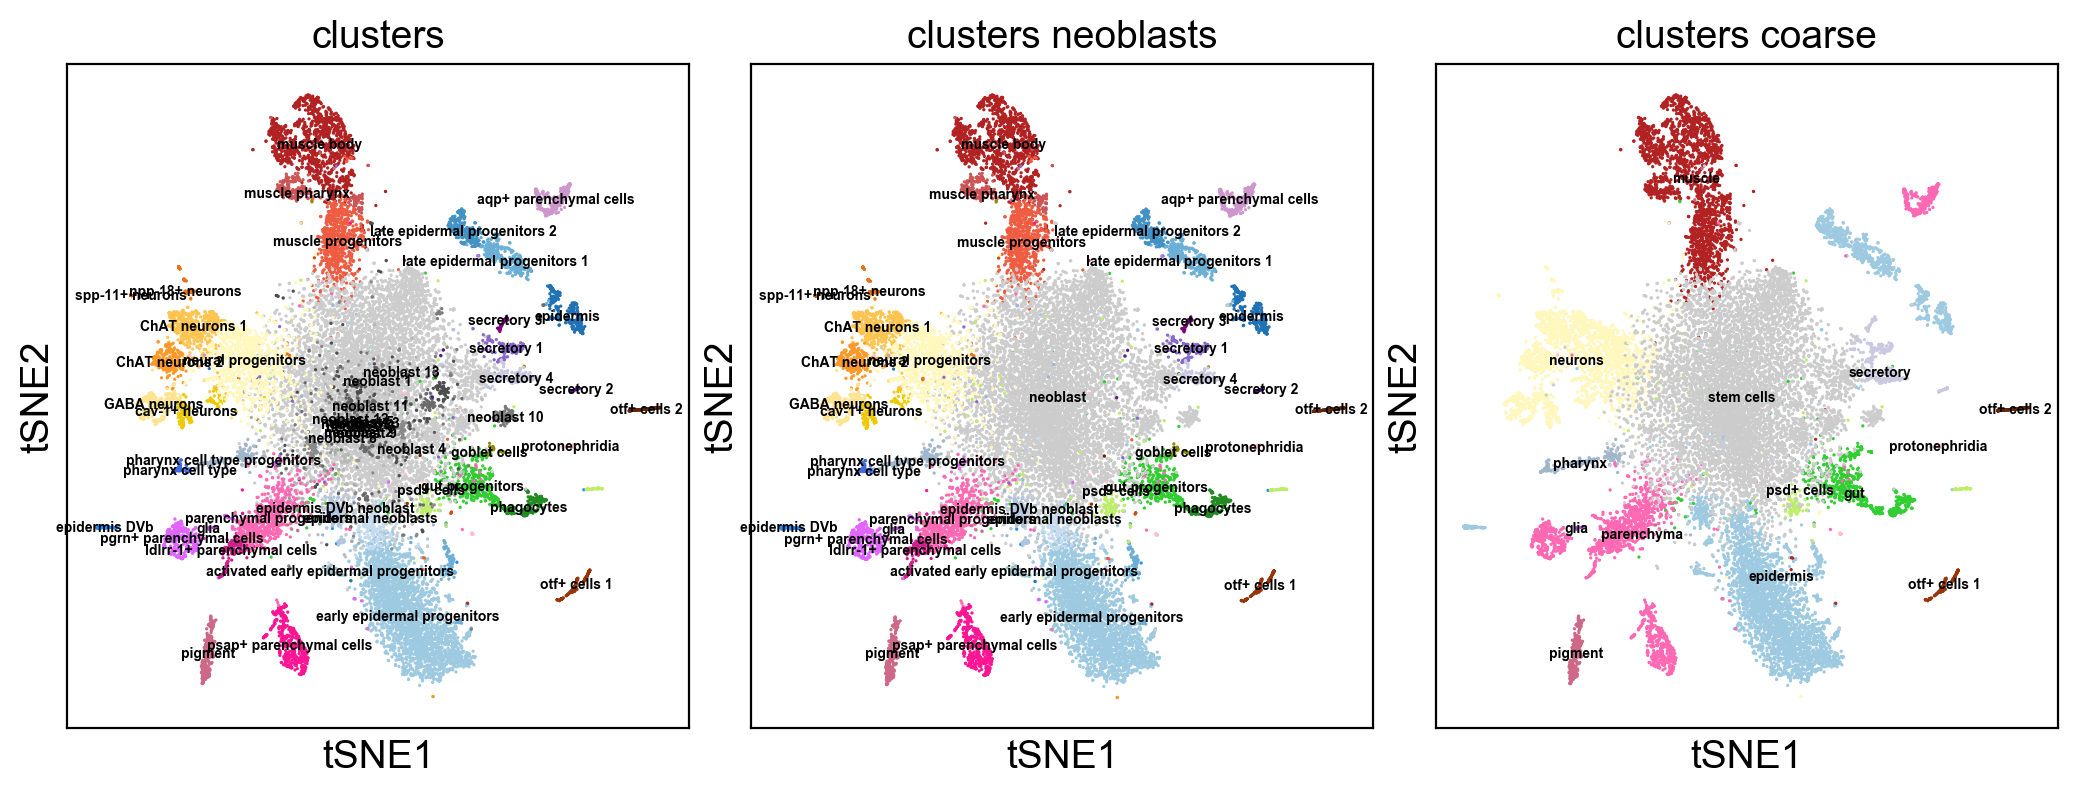

In [9]:
sc.pl.tsne(adata, color=['clusters', 'clusters_neoblasts', 'clusters_coarse'],
           legend_loc='on data', legend_fontsize=5)

saving figure to file ./figures/tsne_coarse.pdf


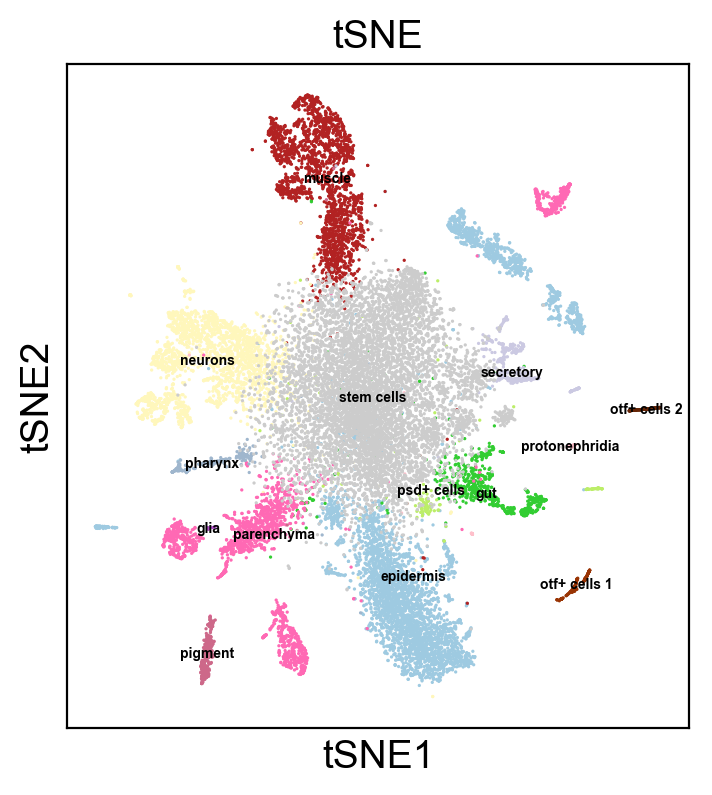

In [10]:
sc.pl.tsne(adata, color='clusters_coarse', title='tSNE',
           legend_loc='on data', legend_fontsize=5, save='_coarse')

saving figure to file ./figures/tsne_fine.pdf


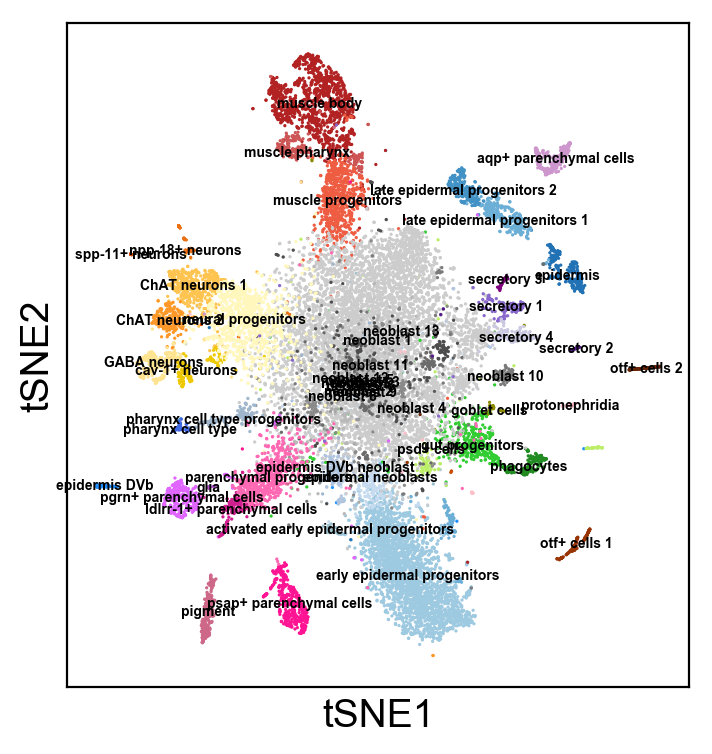

In [11]:
sc.pl.tsne(adata, color='clusters', title='',
           legend_loc='on data', legend_fontsize=5, save='_fine')

Compute the neighborhood graph.

In [12]:
sc.pp.neighbors(adata, n_neighbors=30)

computing neighbors
    using data matrix X directly
    finished (0:00:18.41) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [13]:
adata.write(results_file)

## Cell map from PAGA

Compute a neighborhood graph, use say, 30 neighbors. The choice here doesn't matter too much.

In [2]:
adata = sc.read(results_file)

In [3]:
sc.tl.paga(adata, groups='clusters', model='v1.0')  # changing the model from 1.0 to 1.2 only has minor consequences for the abstracted graph

running partition-based graph abstraction (PAGA)
    finished (0:00:01.61) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


Reproduce the tree layout from [Plass *et al.*, Science (2018)](10.1126/science.aaq1723) - the basis for this is the minimum spanning tree fitted to edges weighted by inverse connectivity - hence, the tree maximizes its summed connectivity. Each path has maximal connectivity.

--> added 'pos', the PAGA positions (adata.uns['paga'])


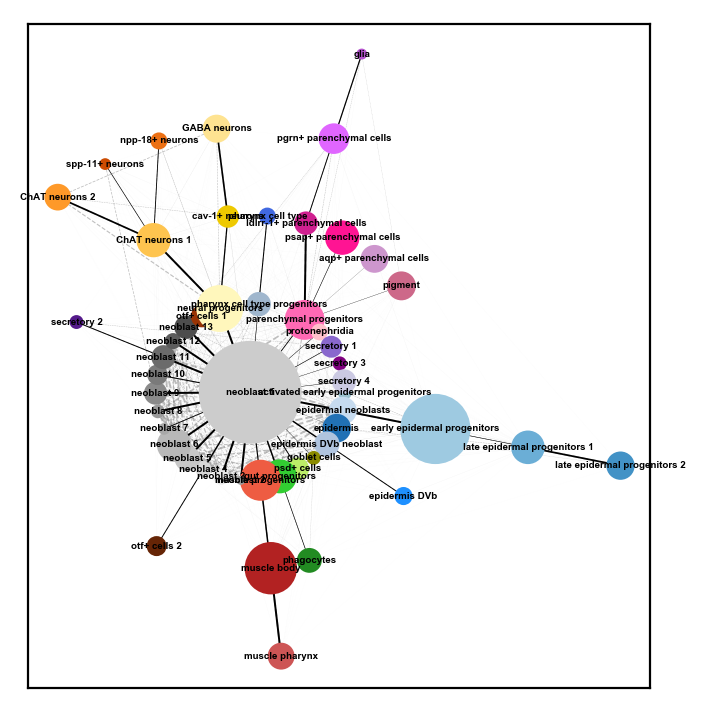

In [4]:
sc.pl.paga(adata,
    threshold=0,           
    solid_edges='connectivities_tree',
    dashed_edges='connectivities', 
    root='neoblast 1',
    layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=3.5)

Let's now not draw this as a tree, but using a FR layout and threshold very weakly connected regions.

--> added 'pos', the PAGA positions (adata.uns['paga'])


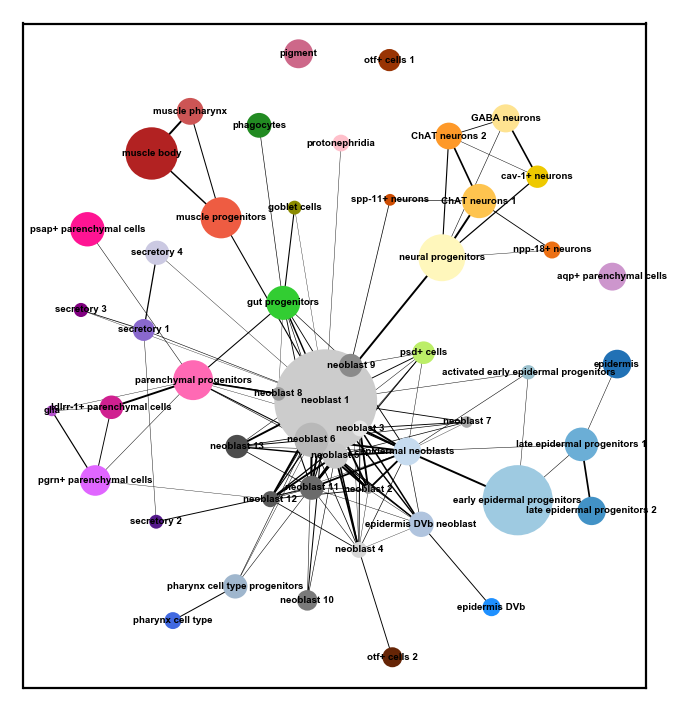

In [18]:
sc.pl.paga(
    adata,
    layout='fr',
    threshold=0.015,
    root='neoblast 1',
    node_size_scale=0.5,
    node_size_power=0.9,
    edge_width_scale=1,
    max_edge_width=0.7,
    fontsize=3.5)

This still looks kind of messy... let's get a very high level overview.

In [9]:
adata_coarse = adata.copy()

In [10]:
sc.tl.paga(adata_coarse, groups='clusters_coarse')

running partition-based graph abstraction (PAGA)
    finished (0:00:01.36) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/confidence', confidence adjacency (adata.uns)
    'paga/confidence_tree', confidence subtree (adata.uns)


Graph has more than a single connected component. To restrict to this component, pass `single_component=True`.
--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_low.pdf


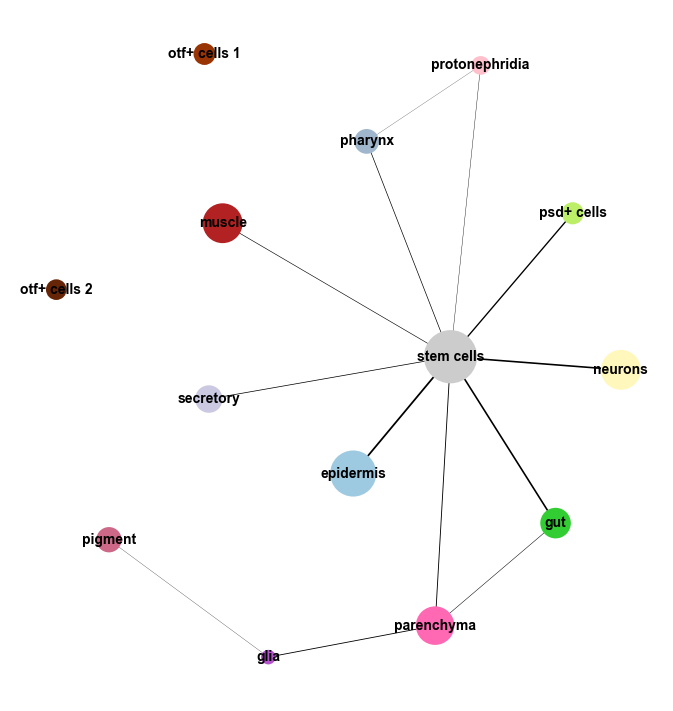

In [29]:
sc.pl.paga(
    adata_coarse,
    layout='fr',
    threshold=0.01,
    fontsize=5,
    node_size_scale=0.5,
    node_size_power=0.5,
    max_edge_width=0.7,
    title='',
    text_kwds={'fontweight': 'bold'},
    frameon=False,
    save='_low')

A reasonable intermediate zooming level is the following, where the neoblasts have been merged.

In [21]:
sc.tl.paga(adata, groups='clusters_neoblasts')

running partition-based graph abstraction (PAGA)
    finished (0:00:01.39) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/confidence', confidence adjacency (adata.uns)
    'paga/confidence_tree', confidence subtree (adata.uns)


Graph has more than a single connected component. To restrict to this component, pass `single_component=True`.
--> added 'pos', the PAGA positions (adata.uns['paga'])


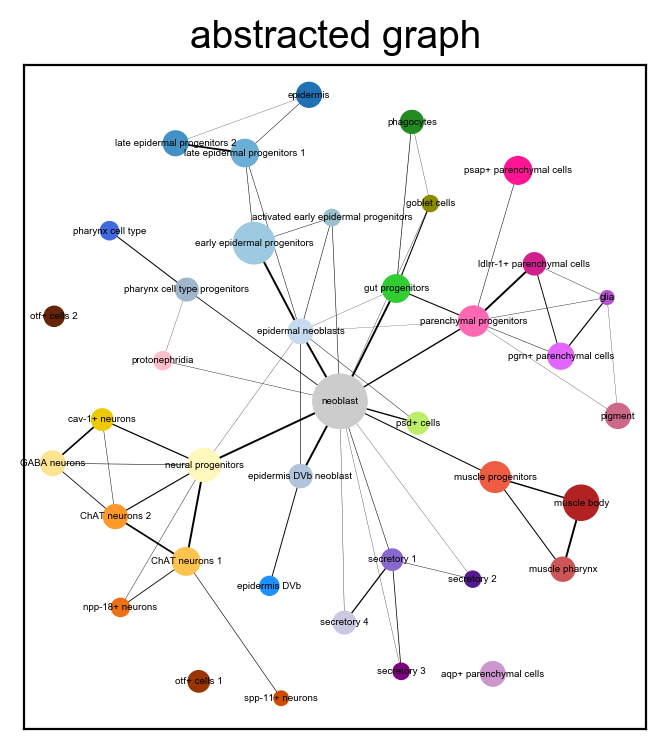

In [22]:
sc.pl.paga(
    adata,
    layout='fr',
    threshold=0.01,
    fontsize=3.5,
    node_size_scale=0.5,
    node_size_power=0.5,
    max_edge_width=0.7)

While the graph with its layout above looks appealing and the embedding is topologically meaningful, we'd like to make it agree more with the coarse grained layout.

For this, let's identify groups with each other and use the positions of the coarse grained clustering as initial positions for our layout.

In [23]:
matches = sc.utils.identify_groups(adata.obs['clusters_neoblasts'], adata.obs['clusters_coarse'])
pos = []
np.random.seed(0)
for i, c in enumerate(adata.obs['clusters_neoblasts'].cat.categories):
    pos_coarse = adata_coarse.uns['paga']['pos']
    coarse_categories = adata.obs['clusters_coarse'].cat.categories
    idx = coarse_categories.get_loc(matches[c][0])
    pos_i = pos_coarse[idx] + np.random.random(2)
    pos.append(pos_i)
pos = np.array(pos)

Graph has more than a single connected component. To restrict to this component, pass `single_component=True`.
--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_intermediate.pdf


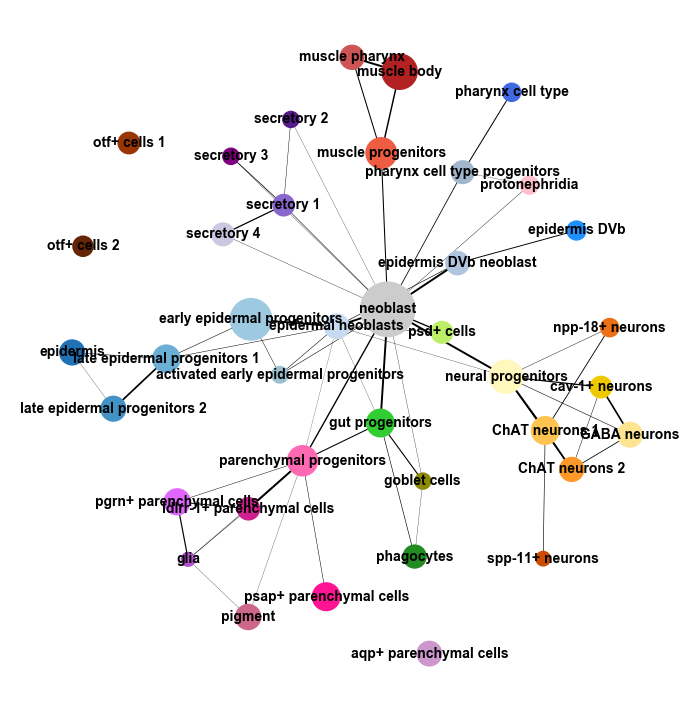

In [30]:
sc.pl.paga(
    adata,
    layout='fr',
    init_pos=pos,
    threshold=0.01,
    fontsize=5,
    node_size_scale=0.5,
    node_size_power=0.5,
    max_edge_width=0.7,
    layout_kwds=dict(maxiter=60,
    maxdelta=0.8,
    repulserad=2),
    title='',
    frameon=False,
    text_kwds={'fontweight': 'bold'},
    save='_intermediate')

While objectively, this does not look better than if starting with a random layout, it indeed agrees better with the layout of the coarse grained clustering.

In [19]:
adata.write(results_file)

## Computing a topologically faithful embedding at single-cell resolution

Let us try UMAP in order to generate a topologicall faithful embedding.

In [2]:
adata = sc.read(results_file)

In [3]:
sc.tl.umap(adata, min_dist=1)

computing UMAP
    finished (0:00:25.72) --> added
    'X_umap', UMAP coordinates (adata.obsm)


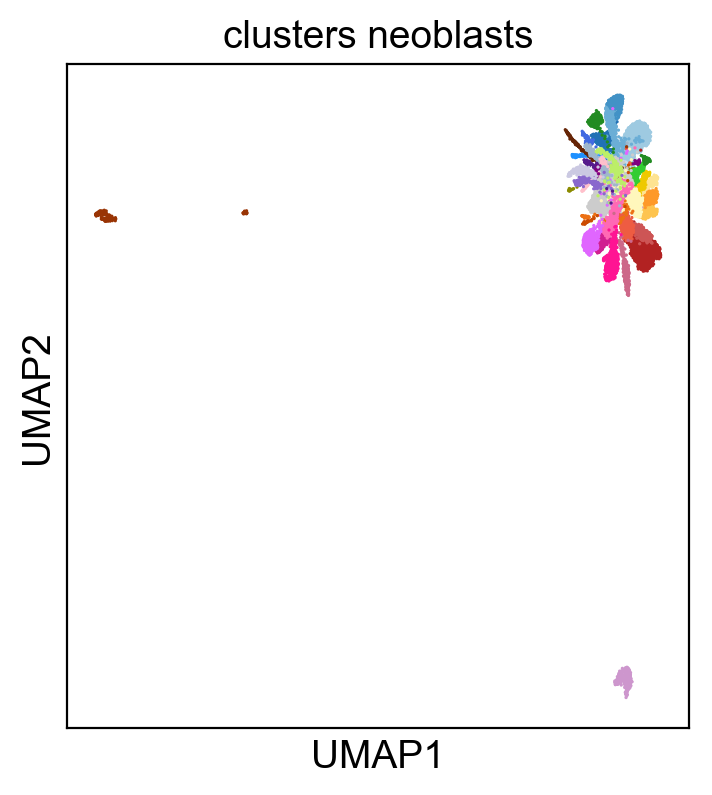

In [4]:
sc.pl.umap(adata, color='clusters_neoblasts', legend_loc='none')

UMAP can't be made to look meaningful even when changing `min_dist` and other parameters.

By far the best looking result is achieved with the following.

In [34]:
adata_copy = adata.copy()
sc.pp.neighbors(adata_copy, n_neighbors=50)
sc.tl.umap(adata_copy, min_dist=0.1)

computing neighbors
    using data matrix X directly
    finished (0:00:20.67) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:30.68) --> added
    'X_umap', UMAP coordinates (adata.obsm)


saving figure to file ./figures/umap_coarse.pdf


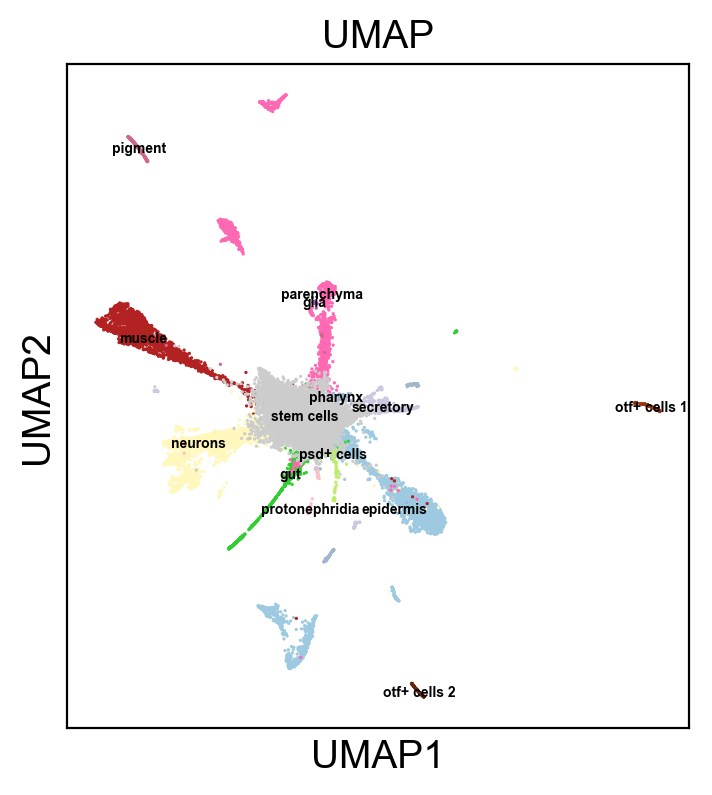

In [35]:
sc.pl.umap(adata_copy, color='clusters_coarse', title='UMAP', legend_loc='on data', legend_fontsize=5, save='_coarse')

Let us now initialize UMAP with this...

In [5]:
sc.tl.umap(adata, init_pos='paga', maxiter=0, min_dist=1)

computing UMAP
    finished (0:00:00.95) --> added
    'X_umap', UMAP coordinates (adata.obsm)


saving figure to file ./figures/umap_paga_init.pdf


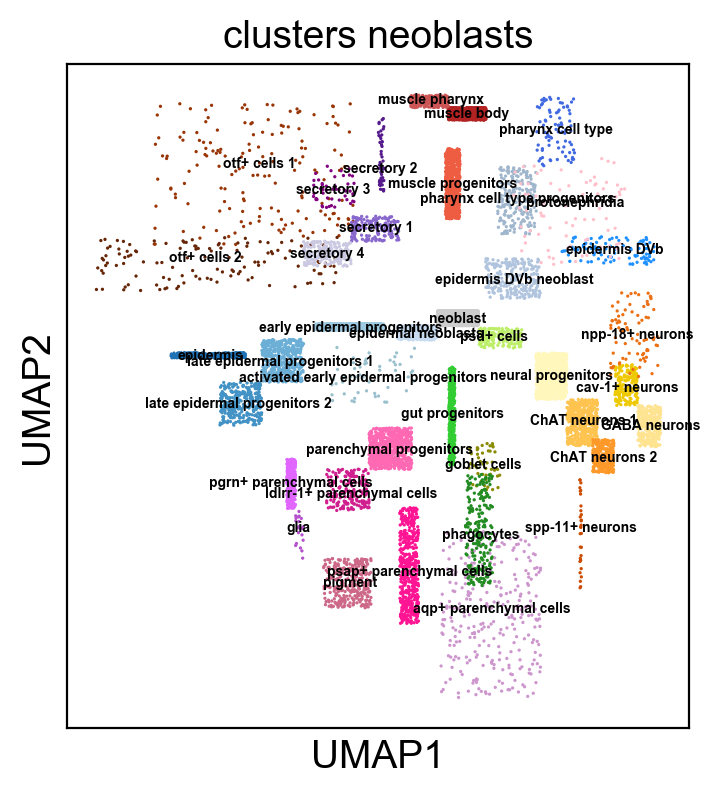

In [6]:
sc.pl.umap(adata, color='clusters_neoblasts', legend_loc='on data', legend_fontsize=5, save='_paga_init')

... and it turns out we get a much nicer picture right away.

In [7]:
sc.tl.umap(adata, init_pos='paga', maxiter=100, min_dist=1)

computing UMAP
    finished (0:00:10.67) --> added
    'X_umap', UMAP coordinates (adata.obsm)


saving figure to file ./figures/umap_paga.pdf


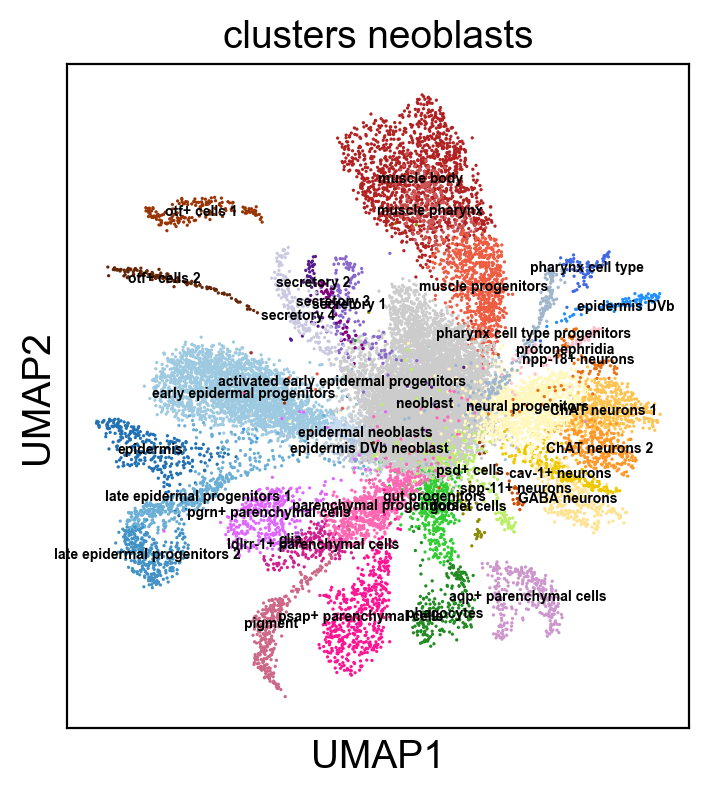

In [41]:
sc.pl.umap(adata, color='clusters_neoblasts', legend_loc='on data', legend_fontsize=5, save='_paga')

In [29]:
sc.tl.draw_graph(adata, init_pos='paga', layout='fa', maxiter=50)

drawing single-cell graph using layout "fa"
    finished (0:00:28.92) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


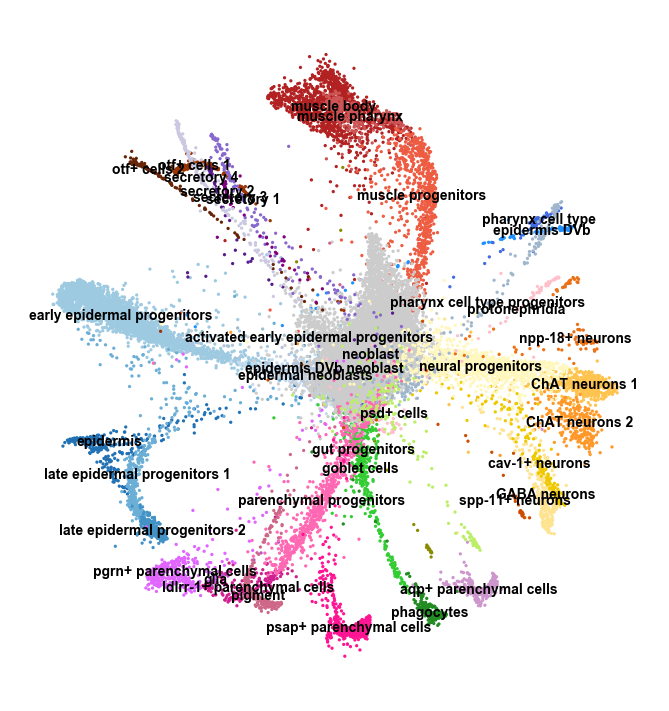

In [66]:
ax = sc.pl.draw_graph(
    adata, color='clusters_neoblasts', title='',
    legend_loc='on data export', legend_fontsize=5, edges=False, show=False)
ax.set_frame_on(False)
ax.set_xlabel('')
ax.set_ylabel('')
pl.savefig('./figures/draw_graph_fa_paga.pdf', dpi=300, transparent=True)
pl.show()

In [ ]:
adata.write(results_file)

Just to check that nothing meaningful happens when not initializing with good initial positions.

In [31]:
adata_copy2 = adata.copy()
sc.tl.draw_graph(adata_copy2, layout='fa', maxiter=100)

drawing single-cell graph using layout "fa"
    finished (0:00:57.08) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


saving figure to file ./figures/draw_graph_fa_coarse.pdf


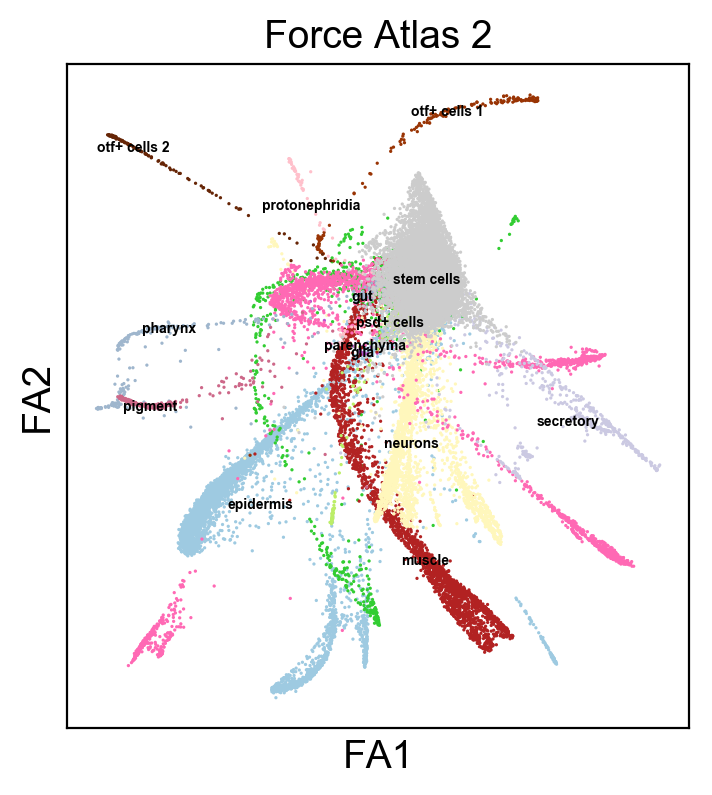

In [33]:
sc.pl.draw_graph(adata_copy2, color='clusters_coarse',
                 title='Force Atlas 2', legend_loc='on data', legend_fontsize=5, save='_coarse')

## Zooming into particular lineages

Let us resolve the epidermal lineage closer.

In [ ]:
adata = sc.read(results_file)

In [40]:
epidermal_clusters = [
    'epidermal neoblasts',
    'early epidermal progenitors',
    'late epidermal progenitors 1',
    'late epidermal progenitors 2', 'epidermis']

In [41]:
adata_epidermis = adata[adata.obs['clusters'].isin(epidermal_clusters)]

In [42]:
sc.tl.paga(adata_epidermis, groups='clusters')

running partition-based graph abstraction (PAGA)
    finished (0:00:00.22) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/confidence', confidence adjacency (adata.uns)
    'paga/confidence_tree', confidence subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


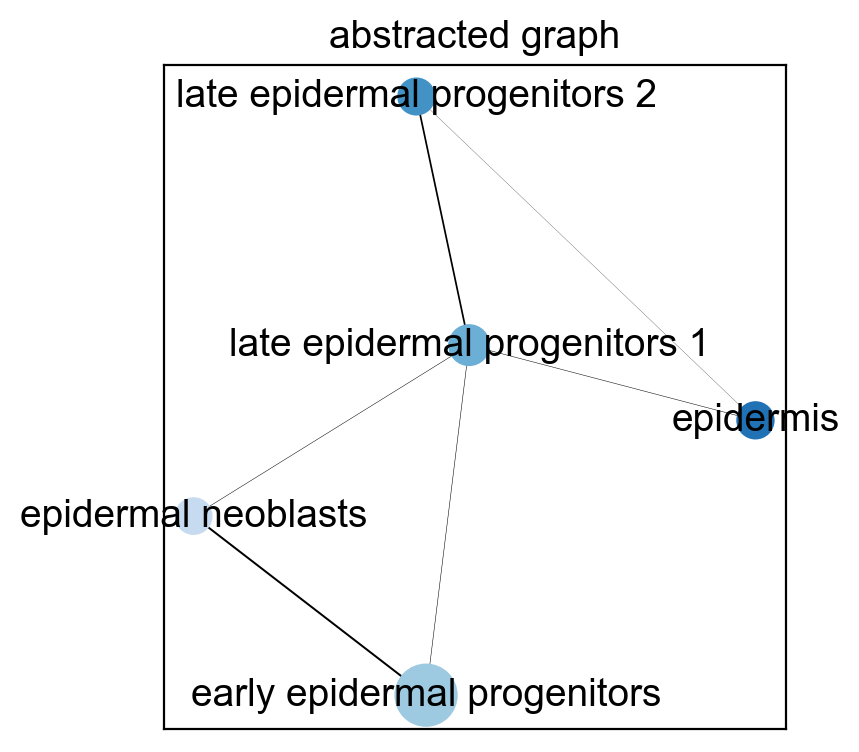

In [43]:
sc.pl.paga(adata_epidermis, threshold=0.01)

In [44]:
sc.tl.umap(adata_epidermis)

computing UMAP
    finished (0:00:08.55) --> added
    'X_umap', UMAP coordinates (adata.obsm)


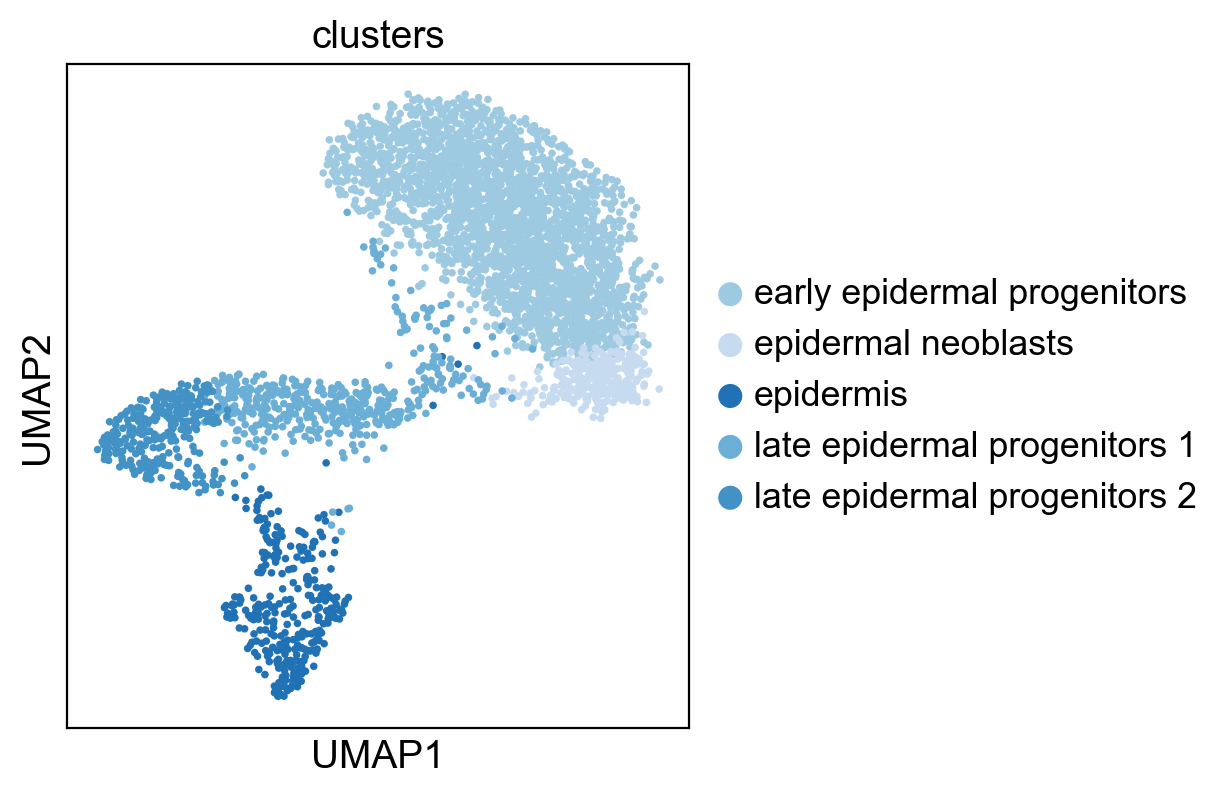

In [45]:
sc.pl.umap(adata_epidermis, color='clusters')

In [46]:
adata_epidermis.write('./write/planaria_pp_extended_epidermis.h5ad')

## Muscle

In [47]:
adata = sc.read(results_file)

In [48]:
muscle_clusters = ['muscle body', 'muscle pharynx', 'muscle progenitors']

In [49]:
adata_muscle = adata[adata.obs['clusters'].isin(muscle_clusters)]

In [50]:
sc.tl.paga(adata_muscle, groups='clusters')

running partition-based graph abstraction (PAGA)
    finished (0:00:00.11) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/confidence', confidence adjacency (adata.uns)
    'paga/confidence_tree', confidence subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


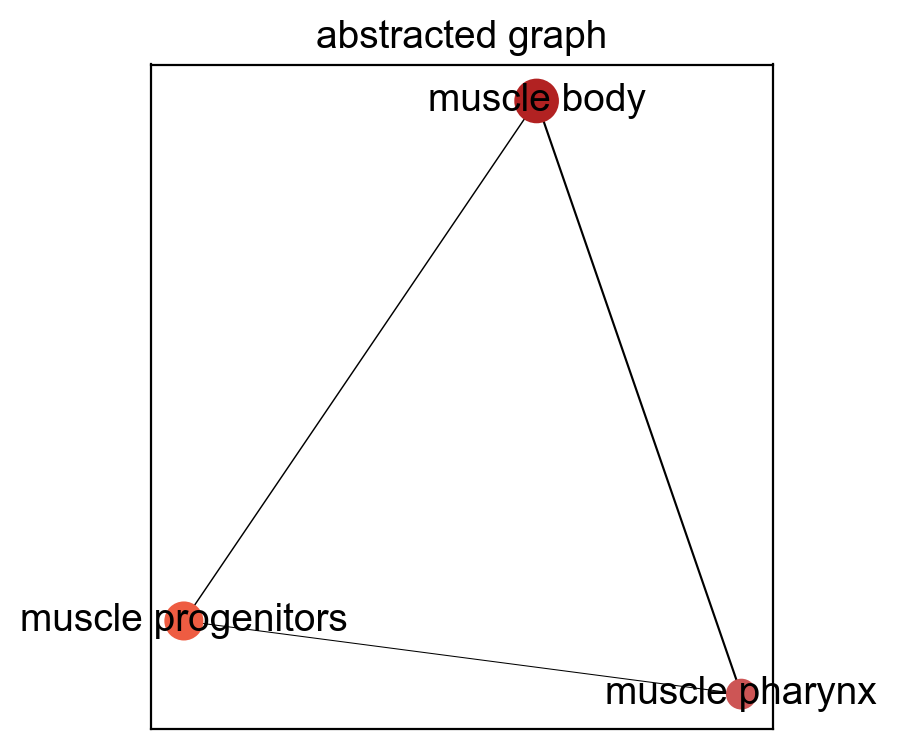

In [51]:
sc.pl.paga(adata_muscle, threshold=0.01)